In [1]:
# Import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Set plots properties
sns.set_style("darkgrid")

In [3]:
# Dataset url
file_url = "https://raw.githubusercontent.com/faadeola/credit-risk-ml-prediction/refs/heads/main/credit_risk_dataset.csv"

# Read dataset for analysis
credit = pd.read_csv(file_url)

# Save a copy of the dataset
credit_copy = credit.copy()

#vShow 10 random rows in the dataset
credit.sample(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
9870,21,65000,MORTGAGE,5.0,DEBTCONSOLIDATION,B,2200,12.42,0,0.03,N,3
11094,26,72000,MORTGAGE,3.0,MEDICAL,A,5000,8.49,0,0.07,N,3
25461,28,72500,RENT,1.0,DEBTCONSOLIDATION,A,12000,7.49,0,0.17,N,6
411,22,49000,RENT,2.0,MEDICAL,E,24000,17.56,1,0.49,N,4
7429,21,28000,RENT,2.0,DEBTCONSOLIDATION,C,6625,13.06,1,0.24,N,2
2542,23,30000,RENT,2.0,VENTURE,A,3000,7.49,0,0.10,N,2
2240,21,24000,RENT,2.0,VENTURE,D,13000,15.70,1,0.54,Y,3
22433,30,48409,RENT,4.0,MEDICAL,B,7000,NaN,0,0.14,N,10
4765,22,31404,RENT,0.0,PERSONAL,A,5000,7.51,0,0.16,N,3
28587,29,105000,MORTGAGE,13.0,MEDICAL,A,12000,7.88,0,0.11,N,10


# Exploratory Data Analysis
This section explores the data file further to understand the structure and distribution

In [4]:
# Shape of the dataset
print(f"Data has {credit.shape[0]} rows and {credit.shape[1]} columns")

Data has 32581 rows and 12 columns


In [5]:
# General overview of the dataset
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
# Display statistical information about the numerical columns
credit.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.73,6.35,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.85,61983.12,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.79,4.14,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.37,6322.09,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.01,3.24,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.17,0.11,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.80,4.06,2.00,3.00,4.00,8.00,30.00


In [8]:
""" Group numerical and categorical data type"""
numerical_columns = credit.select_dtypes(include=["int64","float64"]) #For numerical data types
categorical_columns = credit.select_dtypes(include="object") #For categorical data types

In [11]:
# Get all unique values for categorical columns
for column in categorical_columns:
  print(f"{column}: {credit[column].unique()}")

person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade: ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file: ['Y' 'N']


In [49]:
# Checks for null values
credit.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


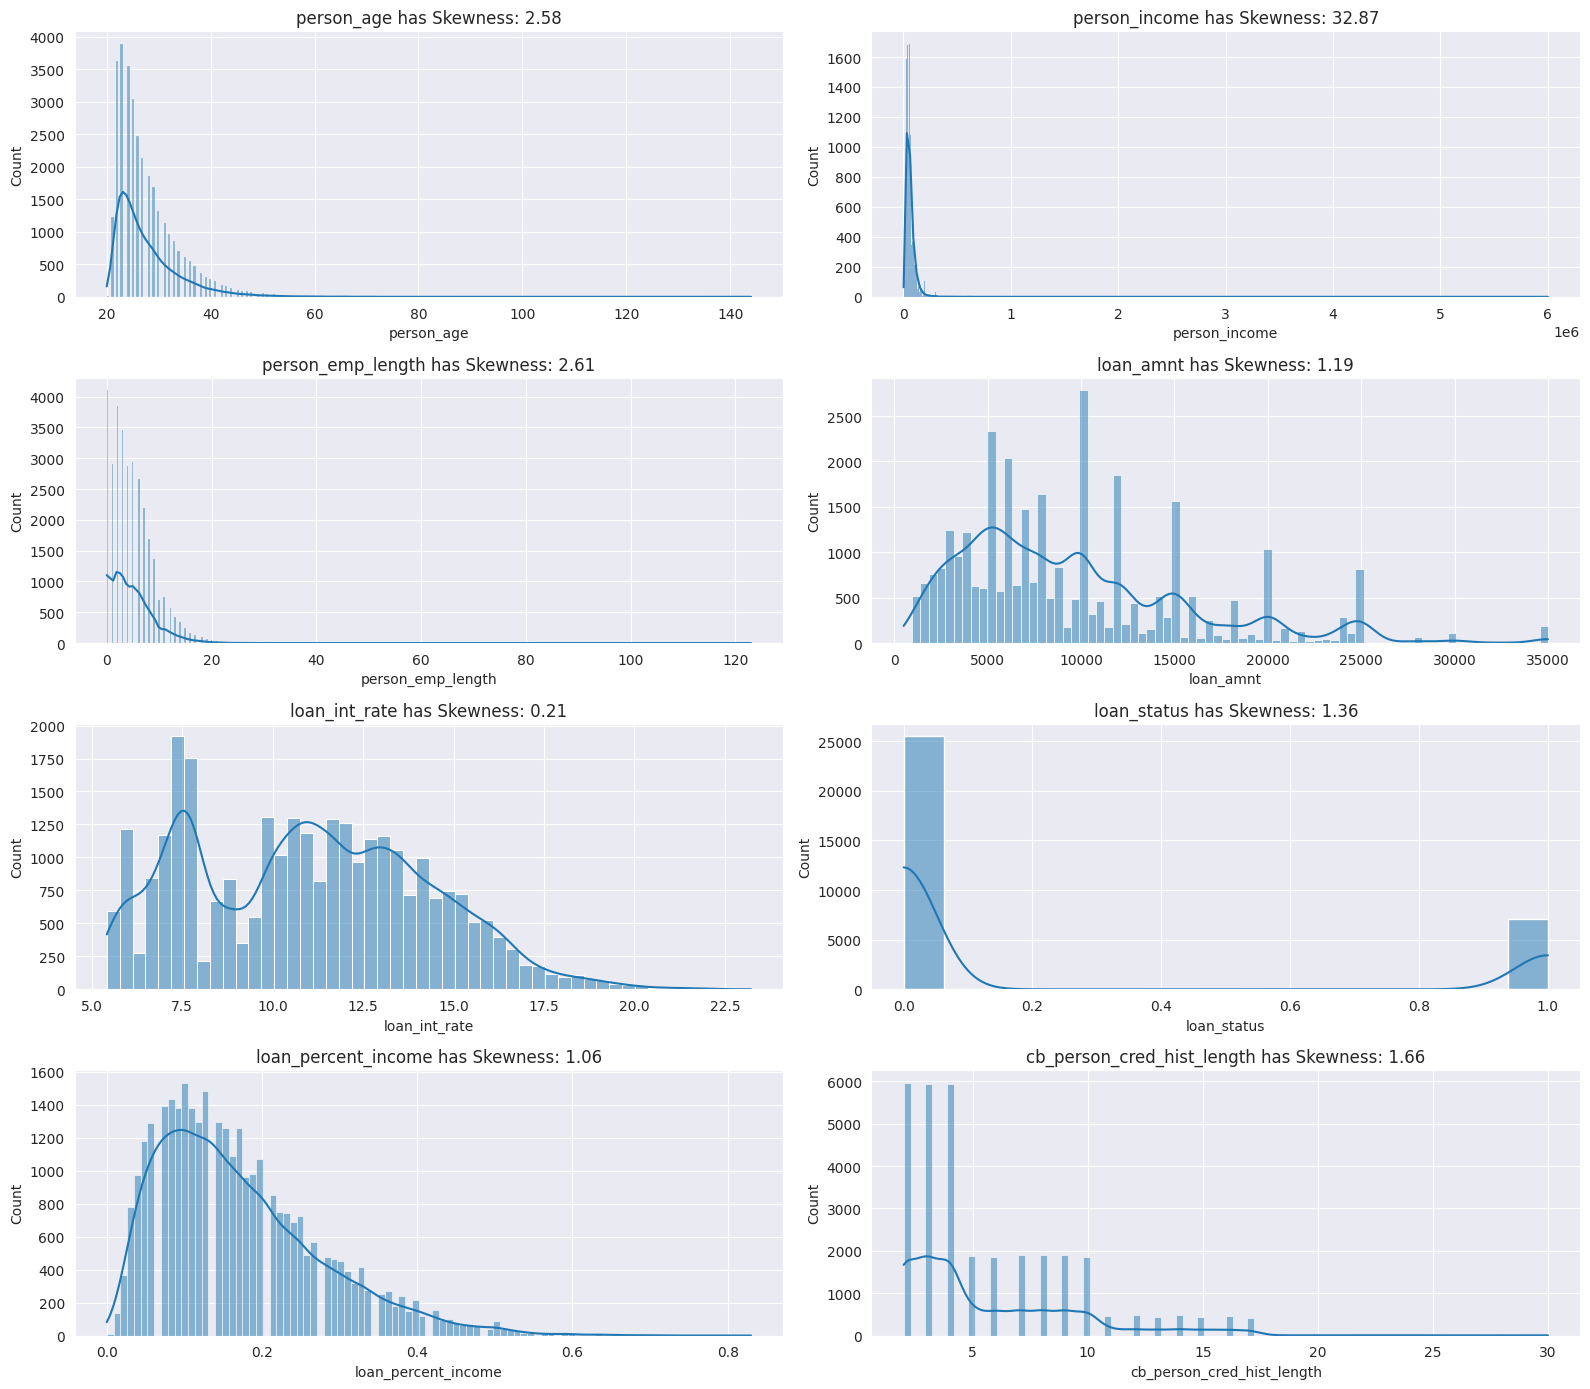

In [34]:
# Plot hitogram of the numerical columns in the dataset to understand data distributions
plt.figure(figsize=(16, 14))
for index, feature in enumerate(numerical_columns, 1):
    plt.subplot(4, 2, index)
    sns.histplot(credit[feature], kde=True, bins="auto")
    plt.title(f"{feature} has Skewness: {round(credit[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

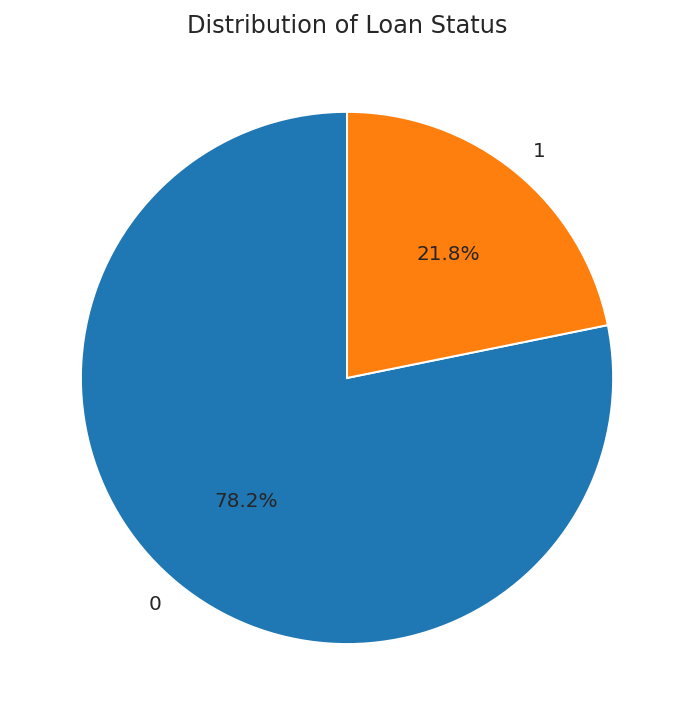

In [39]:
# Distribution of target feature
frequency = credit['loan_status'].value_counts()

fig,ax= plt.subplots(figsize=(8,6),dpi=144)
plt.pie(frequency.values, labels=frequency.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Loan Status')
plt.show()

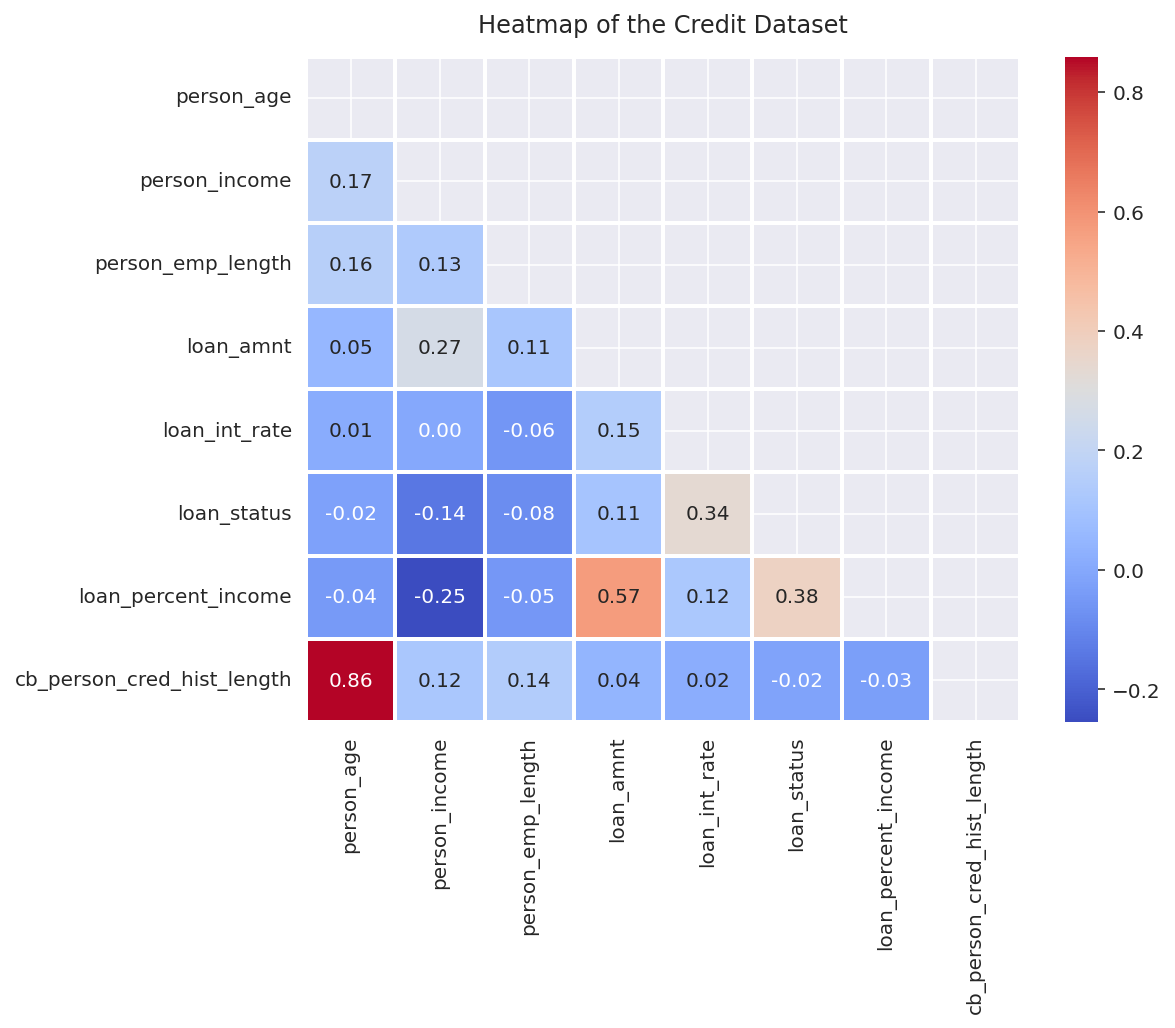

In [48]:
# Heat map of credit data
credit_corr = credit.corr(numeric_only=True)
mask = np.triu(np.ones_like(credit_corr))
plt.subplots(figsize=(8,6),dpi=144)
sns.heatmap(data=credit_corr, mask=mask, fmt=".2f", annot=True, cmap='coolwarm', linewidths=2)
plt.title("Heatmap of the Credit Dataset", pad=12)
plt.xticks(fontsize=10)
plt.show()


# Feature Engineering
Feature modification section for the project

In [ ]:
""" Fill missing values in the order of Mode (categorical data) and Mean (Numerical data) """

#Fill categorical data
for column in categorical_columns:
    if credit[column].isnull().sum() > 0:
        credit[column] = credit[column].fillna(credit[column].mode())

# Fill numerical data
for column in numerical_columns:
    if credit[column].isnull().sum() > 0:
        credit[column] = credit[column].fillna(credit[column].mean())

In [ ]:
# Check if null value still exists
credit.isnull().sum()

In [ ]:
credit['Loan intent'] = credit['Loan intent'].str.replace('DEBTCONSOLIDATION','Debt Consolidation').str.replace('HOMEIMPROVEMENT','Home Improvement')
credit['Loan intent'].value_counts()

In [ ]:
# Standardized values in the object columns to title case
for column in categorical_columns:
    credit[column] = credit[column].str.strip().str.title()

In [ ]:
# Plot the age distribution in the dataset
fig, ax = plt.subplots(figsize=(6,4), dpi=144)
sns.histplot(data=credit, x='person_age', bins= 4 ,kde=True)
plt.grid(alpha=0.5, axis='y')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
"""Classify person into age groups"""
# categorize age into groups
bin = [20,30,40,50,60,120]
age_label = ['20-30','31-40','41-50','51-60','60 and above']

# create group and add to daataset as a new column
credit['Age group'] = pd.cut(credit['Age'],bins=bin, labels=age_label, right=True, include_lowest=True)

In [ ]:
# check for outliers in the data
